In [1]:
import math
from scipy import optimize
import numpy as np

In [2]:
import matplotlib.pyplot as plt

params = {'legend.fontsize': 14,
          'figure.figsize': (14, 8),
         'axes.labelsize': 14,
         'axes.titlesize': 14,
         'xtick.labelsize': 12,
         'ytick.labelsize': 12}
plt.rcParams.update(params)

In [3]:
def gradient_decent(grad, x0, tol, a):
    x = x0
    it = 0
    while True:
        it += 1
        x0 = np.array(x)
        x -= a * np.array(grad(x))
        if all(np.abs(x - x0) < tol):
            x = (x + x0) / 2
            break
    return x, it

In [4]:
eps = 0.001

This wrapper counts the number of function invocations.

In [5]:
class InvocationsCounter:
    def __init__(self, f):
        self.f = f
        self.count = 0
    
    def __call__(self, x, *params):
        self.count += 1
        return self.f(x)

In [6]:
import random

In [13]:
A = random.random()
B = random.random()

A, B

(0.4502224640126733, 0.15681499722874437)

In [14]:
n = 100
xs = [k / n for k in range(n + 1)]
ys = [A * x + B + random.gauss(0, 1) for x in xs]

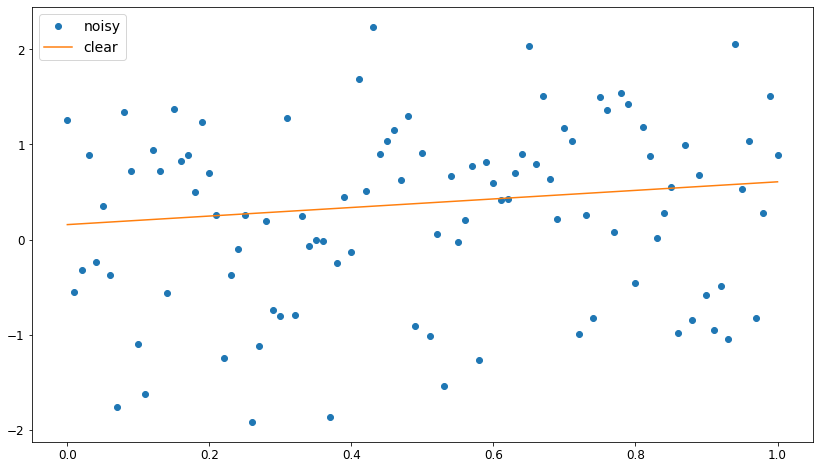

In [15]:
import matplotlib.pyplot as plt

plt.plot(xs, ys, 'o', label='noisy')
plt.plot(xs, [A * x + B for x in xs], label='clear')
plt.legend()
plt.show()

Exhaustive search: a=0.478000, b=0.019000 D(a, b)=87.138310; f calculations 1001000; iterations 1001000
Gauss            : a=0.489981, b=0.010869 D(a, b)=87.140131; f calculations 38; iterations 2
Nelder-Mead      : a=0.477878, b=0.019150 D(a, b)=87.138310; f calculations 58; iterations 30
Gradient decent  : a=0.470466, b=0.022784 D(a, b)=87.138718; f calculations 0; iterations 33; f' calculations 33
CGD              : a=0.477388, b=0.019306 D(a, b)=87.138307; f calculations 5; iterations 2; f' calculations 5
Newton           : a=0.477388, b=0.019306 D(a, b)=87.138307; f calculations 5; iterations 5; f' calculations 5; f'' calculations 5
Levenberg-Marquardt: a=0.477388, b=0.019306 D(a, b)=87.138307; f calculations 4; iterations 2; f' calculations 4


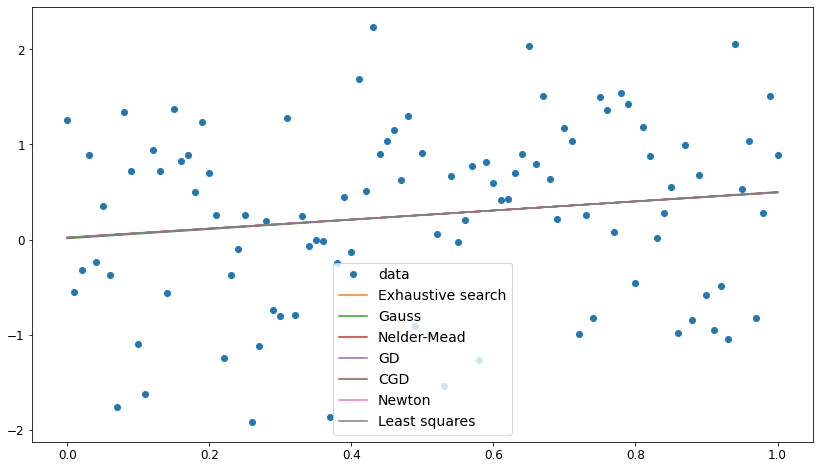

In [35]:
def D(a, b):
    return sum([(a * x + b - y) ** 2 for x, y in zip(xs, ys)])

def f(x, a, b):
    return a * x + b

def G(a, b):
    return [
        sum([2 * (a * x + b - y) * x for x, y in zip(xs, ys)]), # (dD / da) (a, b)
        sum([2 * (a * x + b - y) for x, y in zip(xs, ys)]),     # (aD / db) (a, b)
    ]

def H(a, b):
    return [
        [
            sum(2 * x * x for x in xs),
            sum(2 * x for x in xs)
        ],
        [
            sum(2 * x for x in xs),
            sum(2 for x in xs)
        ]
    ]

d = lambda z: D(z[0], z[1])
g = lambda z: G(z[0], z[1])
h = lambda z: H(z[0], z[1])

plt.plot(xs, ys, 'o', label='data')

counter = InvocationsCounter(d)
a, b = optimize.brute(counter, (slice(0.0, 1.0 + eps, eps), slice(0.0 + eps, 1.0 + eps, eps)), finish=None)
print("Exhaustive search: a=%f, b=%f D(a, b)=%f; f calculations %d; iterations %d" % (a, b, D(a, b), counter.count, counter.count))
plt.plot(xs, [f(x, a, b) for x in xs], label='Exhaustive search')

counter = InvocationsCounter(d)
sol = optimize.minimize(counter, (0.5, 0.5), method='Powell', tol=eps, options={'direc': [(0, 1), (1, 0)]})
print("Gauss            : a=%f, b=%f D(a, b)=%f; f calculations %d; iterations %d" % (sol.x[0], sol.x[1], D(sol.x[0], sol.x[1]), counter.count, sol.nit))
plt.plot(xs, [f(x, sol.x[0], sol.x[1]) for x in xs], label='Gauss')

counter = InvocationsCounter(d)
sol = optimize.minimize(counter, (0.5, 0.5), method='Nelder-Mead', tol=eps)
print("Nelder-Mead      : a=%f, b=%f D(a, b)=%f; f calculations %d; iterations %d" % (sol.x[0], sol.x[1], D(sol.x[0], sol.x[1]), counter.count, sol.nit))
plt.plot(xs, [f(x, sol.x[0], sol.x[1]) for x in xs], label='Nelder-Mead')

counter = InvocationsCounter(d)
grad_counter = InvocationsCounter(g)
sol, iterations = gradient_decent(grad_counter, (0.5, 0.5), tol=eps, a=0.007)
print("Gradient decent  : a=%f, b=%f D(a, b)=%f; f calculations %d; iterations %d; f' calculations %d" % (sol[0], sol[1], D(sol[0], sol[1]), counter.count, iterations, grad_counter.count))
plt.plot(xs, [f(x, sol[0], sol[1]) for x in xs], label='GD')

counter = InvocationsCounter(d)
grad_counter = InvocationsCounter(g)
sol = optimize.minimize(counter, (0.5, 0.5), method='CG', tol=eps, jac=grad_counter)
print("CGD              : a=%f, b=%f D(a, b)=%f; f calculations %d; iterations %d; f' calculations %d" % (sol.x[0], sol.x[1], D(sol.x[0], sol.x[1]), counter.count, sol.nit, grad_counter.count))
plt.plot(xs, [f(x, sol.x[0], sol.x[1]) for x in xs], label='CGD')

counter = InvocationsCounter(d)
grad_counter = InvocationsCounter(g)
hess_counter = InvocationsCounter(h)
sol = optimize.minimize(counter, (0.5, 0.5), method='Newton-CG', tol=eps, jac=grad_counter, hess=hess_counter)
print("Newton           : a=%f, b=%f D(a, b)=%f; f calculations %d; iterations %d; f' calculations %d; f'' calculations %d" % (sol.x[0], sol.x[1], D(sol.x[0], sol.x[1]), counter.count, sol.nit, grad_counter.count, hess_counter.count))
plt.plot(xs, [f(x, sol.x[0], sol.x[1]) for x in xs], label='Newton')

counter = InvocationsCounter(lambda z: z[0] * np.array(xs) + z[1] - np.array(ys))
jac_counter = InvocationsCounter(lambda z: [[x if j == 0 else 1 for j in range(2)] for x in xs])
sol = optimize.least_squares(counter, (0.0, 0.0), method='lm', xtol=eps, jac=jac_counter)
print("Levenberg-Marquardt: a=%f, b=%f D(a, b)=%f; f calculations %d; iterations %d; f' calculations %d" % (sol.x[0], sol.x[1], D(sol.x[0], sol.x[1]), counter.count, sol.nfev, jac_counter.count))
plt.plot(xs, [f(x, sol.x[0], sol.x[1]) for x in xs], label='Least squares')

plt.legend()
plt.show()

Exhaustive search: a=0.160000, b=-0.674000 D(a, b)=87.822930; f calculations 4002000; iterations 4002000
Gauss            : a=0.160406, b=-0.673092 D(a, b)=87.822911; f calculations 103; iterations 4
Nelder-Mead      : a=0.160597, b=-0.672044 D(a, b)=87.822905; f calculations 102; iterations 53
Gradient decent  : a=0.177281, b=-0.601054 D(a, b)=87.862954; f calculations 0; iterations 306; f' calculations 306
CGD              : a=0.160480, b=-0.672391 D(a, b)=87.822903; f calculations 21; iterations 8; f' calculations 21
Newton           : a=0.164093, b=-0.657557 D(a, b)=87.824884; f calculations 32; iterations 28; f' calculations 32; f'' calculations 28
Levenberg-Marquardt: a=0.160509, b=-0.672280 D(a, b)=87.822904; f calculations 16; iterations 14; f' calculations 13


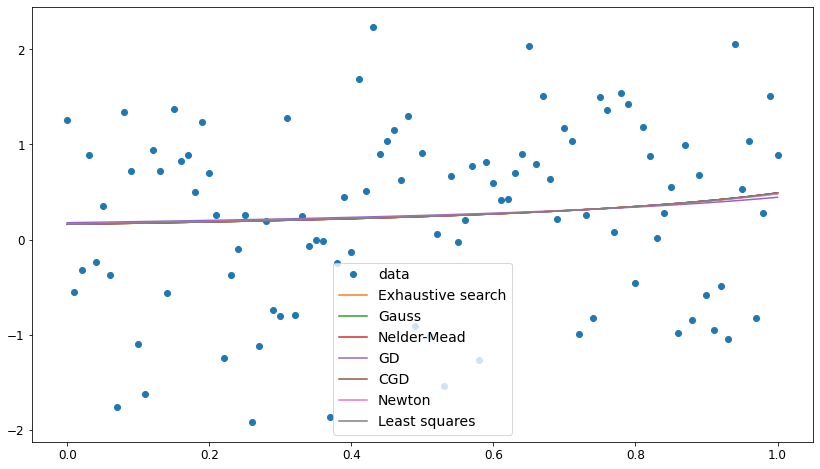

In [36]:
def D(a, b):
    return sum([(a / (1 + x * b) - y) ** 2 for x, y in zip(xs, ys)])

def f(x, a, b):
    return a / (1 + x * b)

def G(a, b):
    return [
        sum([2 * (a / (1 + x * b) - y) / (1 + x * b) for x, y in zip(xs, ys)]), # (dD / da) (a, b)
        sum([2 * (a / (1 + x * b) - y) * (-a * x) / ((1 + x * b) ** 2) for x, y in zip(xs, ys)]),     # (aD / db) (a, b)
    ]

def H(a, b):
    return [
        [
            sum(2 / ((1 + b * x) ** 2) for x in xs),
            sum(-2 * a * x / ((1 + b * x) ** 2) - 2 * x / ((1 + b * x) ** 2) * (a / (1 + b * x) - y) for x, y in zip(xs, ys))
        ],
        [
            sum(-2 * a * x / ((1 + b * x) ** 2) - 2 * x / ((1 + b * x) ** 2) * (a / (1 + b * x) - y) for x, y in zip(xs, ys)),
            sum(2 * (a * x / ((1 + b * x) ** 2)) ** 2 + 2 * (a / (1 + b * x) - y) * 2 * a * x * x / ((1 + b * x) ** 3) for x, y in zip(xs, ys))
        ]
    ]

d = lambda z: D(z[0], z[1])
g = lambda z: G(z[0], z[1])
h = lambda z: H(z[0], z[1])

plt.plot(xs, ys, 'o', label='data')

counter = InvocationsCounter(d)
a, b = optimize.brute(counter, (slice(-1.0, 1.0 + eps, eps), slice(-1.0 + eps, 1.0 + eps, eps)), finish=None)
print("Exhaustive search: a=%f, b=%f D(a, b)=%f; f calculations %d; iterations %d" % (a, b, D(a, b), counter.count, counter.count))
plt.plot(xs, [f(x, a, b) for x in xs], label='Exhaustive search')

counter = InvocationsCounter(d)
sol = optimize.minimize(counter, (0.0, 0.0), method='Powell', tol=eps, options={'direc': [(0, 1), (1, 0)]})
print("Gauss            : a=%f, b=%f D(a, b)=%f; f calculations %d; iterations %d" % (sol.x[0], sol.x[1], D(sol.x[0], sol.x[1]), counter.count, sol.nit))
plt.plot(xs, [f(x, sol.x[0], sol.x[1]) for x in xs], label='Gauss')

counter = InvocationsCounter(d)
sol = optimize.minimize(counter, (0.0, 0.0), method='Nelder-Mead', tol=eps)
print("Nelder-Mead      : a=%f, b=%f D(a, b)=%f; f calculations %d; iterations %d" % (sol.x[0], sol.x[1], D(sol.x[0], sol.x[1]), counter.count, sol.nit))
plt.plot(xs, [f(x, sol.x[0], sol.x[1]) for x in xs], label='Nelder-Mead')

counter = InvocationsCounter(d)
grad_counter = InvocationsCounter(g)
sol, iterations = gradient_decent(grad_counter, (0.0, 0.0), tol=eps, a=0.001)
print("Gradient decent  : a=%f, b=%f D(a, b)=%f; f calculations %d; iterations %d; f' calculations %d" % (sol[0], sol[1], D(sol[0], sol[1]), counter.count, iterations, grad_counter.count))
plt.plot(xs, [f(x, sol[0], sol[1]) for x in xs], label='GD')

counter = InvocationsCounter(d)
grad_counter = InvocationsCounter(g)
sol = optimize.minimize(counter, (0.0, 0.0), method='CG', tol=eps, jac=grad_counter)
print("CGD              : a=%f, b=%f D(a, b)=%f; f calculations %d; iterations %d; f' calculations %d" % (sol.x[0], sol.x[1], D(sol.x[0], sol.x[1]), counter.count, sol.nit, grad_counter.count))
plt.plot(xs, [f(x, sol.x[0], sol.x[1]) for x in xs], label='CGD')

counter = InvocationsCounter(d)
grad_counter = InvocationsCounter(g)
hess_counter = InvocationsCounter(h)
sol = optimize.minimize(counter, (0.5, 0.5), method='Newton-CG', tol=eps, jac=grad_counter, hess=hess_counter)
print("Newton           : a=%f, b=%f D(a, b)=%f; f calculations %d; iterations %d; f' calculations %d; f'' calculations %d" % (sol.x[0], sol.x[1], D(sol.x[0], sol.x[1]), counter.count, sol.nit, grad_counter.count, hess_counter.count))
plt.plot(xs, [f(x, sol.x[0], sol.x[1]) for x in xs], label='Newton')

counter = InvocationsCounter(lambda z: z[0] * np.array([1 / (1 + x * z[1]) for x in xs]) - np.array(ys))
jac_counter = InvocationsCounter(lambda z: [[1 / (1 + z[1] * x) if j == 0 else -z[0] * x / ((1 + z[1] * x) ** 2) for j in range(2)] for x in xs])
sol = optimize.least_squares(counter, (0.0, 0.0), method='lm', xtol=eps, jac=jac_counter)
print("Levenberg-Marquardt: a=%f, b=%f D(a, b)=%f; f calculations %d; iterations %d; f' calculations %d" % (sol.x[0], sol.x[1], D(sol.x[0], sol.x[1]), counter.count, sol.nfev, jac_counter.count))
plt.plot(xs, [f(x, sol.x[0], sol.x[1]) for x in xs], label='Least squares')

plt.legend()
plt.show()